In [ ]:
import os
import random
import subprocess
import cv2

In [ ]:
base_path = "CS593"
resized_videos_path = os.path.join(base_path, 'resized_videos')
processed_frames_path = os.path.join(base_path, 'processed_frames')

Resize the videos

In [ ]:
def resize_videos(input_folder, output_folder, resolution=(256, 256), num_folders=50):
    # Get all subfolders in the input folder
    all_folders = [folder for folder in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, folder))]
    if len(all_folders) < num_folders:
        print(f"Not enough folders to select {num_folders}. Proceeding with all available folders.")
        selected_folders = all_folders
    else:
        selected_folders = random.sample(all_folders, num_folders)  # Randomly select folders

    os.makedirs(output_folder, exist_ok=True)

    for label_folder in selected_folders:
        label_input_path = os.path.join(input_folder, label_folder)
        label_output_path = os.path.join(output_folder, label_folder)
        os.makedirs(label_output_path, exist_ok=True)

        for video_file in os.listdir(label_input_path):
            if not video_file.endswith('.mp4'):  # Handle only .mp4 files
                continue
            input_video_path = os.path.join(label_input_path, video_file)
            output_video_path = os.path.join(label_output_path, video_file)
            # Resize using ffmpeg
            cmd = f"ffmpeg -i '{input_video_path}' -vf scale={resolution[0]}:{resolution[1]} '{output_video_path}'"
            result = subprocess.run(cmd, shell=True, stderr=subprocess.PIPE)
            if result.returncode != 0:
                print(f"Error resizing {input_video_path}: {result.stderr.decode()}")

resize_videos(os.path.join(base_path, 'train'), resized_videos_path, resolution=(256, 256), num_folders=50)

Frame Extraction

In [ ]:
def extract_informative_frames_from_folders(input_folder, output_folder, fps=5, threshold=30):
    """
    Extracts frames with significant motion from all videos in labeled folders.

    Parameters:
    - input_folder: Path to the root folder containing labeled video folders.
    - output_folder: Path to save extracted frames organized by labels.
    - fps: Number of frames per second to sample.
    - threshold: Motion threshold to detect significant changes.
    """
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through all label folders
    for label_folder in os.listdir(input_folder):
        label_input_path = os.path.join(input_folder, label_folder)
        if not os.path.isdir(label_input_path):
            continue

        label_output_path = os.path.join(output_folder, label_folder)
        os.makedirs(label_output_path, exist_ok=True)

        # Process all .mp4 files in the label folder
        for video_file in os.listdir(label_input_path):
            if not video_file.endswith('.mp4'):
                continue

            video_path = os.path.join(label_input_path, video_file)
            video_output_path = os.path.join(label_output_path, os.path.splitext(video_file)[0])
            os.makedirs(video_output_path, exist_ok=True)

            cap = cv2.VideoCapture(video_path)
            prev_frame = None
            frame_count = 0
            saved_frame_count = 0
            frame_rate = cap.get(cv2.CAP_PROP_FPS)
            if frame_rate == 0 or frame_rate is None:
                print(f"Skipping {video_path} due to unreadable frame rate.")
                continue

            interval = int(frame_rate / fps)

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                frame_count += 1
                if frame_count % interval != 0:
                    continue

                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                if prev_frame is not None:
                    diff = cv2.absdiff(prev_frame, gray_frame)
                    motion_score = diff.mean()

                    if motion_score > threshold:
                        frame_filename = os.path.join(video_output_path, f"frame_{saved_frame_count:04d}.jpg")
                        cv2.imwrite(frame_filename, frame)
                        saved_frame_count += 1

                prev_frame = gray_frame

            cap.release()
            print(f"Extracted {saved_frame_count} frames with significant motion from {video_path}")

extract_informative_frames_from_folders(resized_videos_path, processed_frames_path, fps=5, threshold=30)

In [1]:
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, RandomRotation, ColorJitter, Resize, ToTensor, Normalize
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
import os
from PIL import Image
import torch
from torchvision.transforms import (
    Compose, RandomHorizontalFlip, RandomRotation, ColorJitter,
    RandomResizedCrop, GaussianBlur, RandomPerspective
)
from tqdm import tqdm

class BalancedAugmentor:
    def __init__(self, root_dir, target_count=100, transform=None):
        """
        Args:
            root_dir (str): Path to the original dataset root directory.
            target_count (int): Desired number of images per action label after augmentation.
            transform (callable, optional): Transform to apply for augmentation.
        """
        self.root_dir = root_dir
        self.target_count = target_count
        self.transform = transform if transform else self.default_augmentation()

    def default_augmentation(self):
        """
        Defines the augmentation pipeline for intense augmentation.
        """
        return Compose([
            RandomResizedCrop(size=(224, 224), scale=(0.8, 1.2)),  # Random crop and resize
            RandomHorizontalFlip(p=0.5),
            RandomRotation(degrees=30),  # Random rotation
            ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
            GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),
            RandomPerspective(distortion_scale=0.5, p=0.5),
        ])

    def augment_class(self, label_dir, label, current_count):
        """
        Augments a specific class to reach the target number of images.
        Args:
            label_dir (str): Directory containing images for the specific class label.
            label (str): Name of the label.
            current_count (int): Current number of images in the class folder.
        """
        image_files = os.listdir(label_dir)
        num_to_augment = self.target_count - current_count

        if num_to_augment > 0:
            print(f"Augmenting class '{label}' with {num_to_augment} new images.")
            for i in range(num_to_augment):
                img_path = os.path.join(label_dir, image_files[i % len(image_files)])
                img = Image.open(img_path).convert("RGB")  # Ensure all images are in RGB mode

                # Apply augmentation
                augmented_img = self.transform(img)

                # Save augmented image
                augmented_img_path = os.path.join(label_dir, f"{label}_aug_{i}.jpg")
                augmented_img.save(augmented_img_path)

    def balance_dataset(self):
        """
        Balances all classes by augmenting underrepresented ones.
        """
        action_labels = os.listdir(self.root_dir)
        for label in tqdm(action_labels, desc="Balancing Classes"):
            label_dir = os.path.join(self.root_dir, label)
            if not os.path.isdir(label_dir):
                continue  # Skip if it's not a directory
            current_count = len(os.listdir(label_dir))
            if current_count < self.target_count:
                self.augment_class(label_dir, label, current_count)

# Parameters
root_dir = 'action_sp'  # Original dataset path
target_count = 200  # Desired number of images per action label

# Perform balancing augmentation
augmentor = BalancedAugmentor(root_dir, target_count=target_count)
augmentor.balance_dataset()

# Verify final counts
final_counts = {label: len(os.listdir(os.path.join(root_dir, label))) for label in os.listdir(root_dir)}
print(f"Final image counts per class: {final_counts}")


Balancing Classes:   0%|          | 0/21 [00:00<?, ?it/s]

Augmenting class 'giving or receiving award' with 69 new images.


Balancing Classes:   5%|▍         | 1/21 [00:00<00:10,  1.91it/s]

Augmenting class 'wrapping present' with 85 new images.


Balancing Classes:  10%|▉         | 2/21 [00:00<00:08,  2.14it/s]

Augmenting class 'wrestling' with 85 new images.


Balancing Classes:  14%|█▍        | 3/21 [00:01<00:07,  2.40it/s]

Augmenting class 'answering questions' with 84 new images.


Balancing Classes:  19%|█▉        | 4/21 [00:01<00:07,  2.14it/s]

Augmenting class 'checking tires' with 85 new images.


Balancing Classes:  24%|██▍       | 5/21 [00:02<00:06,  2.30it/s]

Augmenting class 'air drumming' with 78 new images.


Balancing Classes:  29%|██▊       | 6/21 [00:02<00:06,  2.43it/s]

Augmenting class 'playing trombone' with 85 new images.


Balancing Classes:  33%|███▎      | 7/21 [00:02<00:05,  2.58it/s]

Augmenting class 'milking cow' with 78 new images.


Balancing Classes:  38%|███▊      | 8/21 [00:03<00:04,  2.73it/s]

Augmenting class 'applauding' with 82 new images.


Balancing Classes:  43%|████▎     | 9/21 [00:03<00:04,  2.78it/s]

Augmenting class 'moving furniture' with 85 new images.


Balancing Classes:  48%|████▊     | 10/21 [00:03<00:03,  2.80it/s]

Augmenting class 'abseiling' with 65 new images.


Balancing Classes:  52%|█████▏    | 11/21 [00:04<00:03,  2.92it/s]

Augmenting class 'pushing wheelchair' with 85 new images.


Balancing Classes:  57%|█████▋    | 12/21 [00:04<00:03,  2.69it/s]

Augmenting class 'riding elephant' with 85 new images.


Balancing Classes:  62%|██████▏   | 13/21 [00:05<00:03,  2.65it/s]

Augmenting class 'opening bottle' with 83 new images.


Balancing Classes:  67%|██████▋   | 14/21 [00:05<00:02,  2.66it/s]

Augmenting class 'playing harp' with 80 new images.


Balancing Classes:  71%|███████▏  | 15/21 [00:05<00:02,  2.77it/s]

Augmenting class 'applying cream' with 82 new images.


Balancing Classes:  76%|███████▌  | 16/21 [00:06<00:01,  2.84it/s]

Augmenting class 'throwing axe' with 82 new images.


Balancing Classes:  81%|████████  | 17/21 [00:06<00:01,  2.85it/s]

Augmenting class 'archery' with 66 new images.


Balancing Classes:  86%|████████▌ | 18/21 [00:06<00:01,  2.91it/s]

Augmenting class 'doing aerobics' with 80 new images.


Balancing Classes:  90%|█████████ | 19/21 [00:07<00:00,  2.70it/s]

Augmenting class 'juggling soccer ball' with 81 new images.


Balancing Classes:  95%|█████████▌| 20/21 [00:07<00:00,  2.58it/s]

Augmenting class 'waxing chest' with 85 new images.


Balancing Classes: 100%|██████████| 21/21 [00:08<00:00,  2.60it/s]

Final image counts per class: {'giving or receiving award': 131, 'wrapping present': 115, 'wrestling': 115, 'answering questions': 200, 'checking tires': 115, 'air drumming': 122, 'playing trombone': 115, 'milking cow': 122, 'applauding': 118, 'moving furniture': 115, 'abseiling': 135, 'pushing wheelchair': 115, 'riding elephant': 115, 'opening bottle': 117, 'playing harp': 120, 'applying cream': 118, 'throwing axe': 118, 'archery': 134, 'doing aerobics': 120, 'juggling soccer ball': 119, 'waxing chest': 115}


In [3]:
def count_images_in_folder(folder_path, extensions=('jpg', 'jpeg', 'png')):
    total_images = 0
    
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(extensions):
                total_images += 1
                
            
    return total_images

# Example usage
folder_path = "action_sp"  # Replace with your folder path
total_images = count_images_in_folder(folder_path)
print(f"Total images: {total_images}")

Total images: 2592


In [34]:
def visualize_attention(video_frames, spatial_weights, temporal_weights):
    """
    Visualize attention over video frames, spatial weights, and temporal weights.

    Args:
        video_frames (torch.Tensor): Shape [batch_size, 3, num_frames, height, width].
        spatial_weights (torch.Tensor): Shape [batch_size, num_frames, num_frames].
        temporal_weights (torch.Tensor): Shape [batch_size, num_frames, num_frames].
    """
    num_frames, height, width = video_frames.shape[2], video_frames.shape[3], video_frames.shape[4]

    # Normalize spatial weights for visualization
    spatial_weights_normalized = spatial_weights.cpu().detach().numpy()
    temporal_weights_normalized = temporal_weights.cpu().detach().numpy()

    # Visualize frames
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    for i in range(num_frames):
        frame = video_frames[0, :, i, :, :].permute(1, 2, 0).cpu().numpy()
        axes[i].imshow((frame - frame.min()) / (frame.max() - frame.min()))  # Normalize frame
        axes[i].set_title(f"Frame {i + 1}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    # Visualize spatial attention for the first batch
    plt.figure(figsize=(8, 6))
    plt.imshow(spatial_weights_normalized[0], cmap='hot', interpolation='nearest')
    plt.title("Spatial Attention (Frame-to-Frame Relationships)")
    plt.colorbar()
    plt.show()

    # Visualize temporal attention for the first batch
    plt.figure(figsize=(8, 6))
    plt.imshow(temporal_weights_normalized[0], cmap='hot', interpolation='nearest')  # First batch only
    plt.title("Temporal Attention (Frame-to-Frame Relationships)")
    plt.colorbar()
    plt.show()


In [27]:
# Dataset class for images
class ActionVideoFromImagesDataset(Dataset):
    def __init__(self, root_dir, num_frames=16, transform=None):
        """
        Args:
            root_dir (str): Path to the root directory containing action label folders.
            num_frames (int): Number of frames to sample per pseudo-video.
            transform (callable, optional): Transform to apply to each frame.
        """
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.transform = transform
        self.data = []
        self.labels = []
        self.classes = os.listdir(root_dir)

        # Load dataset: Store paths of image files and corresponding labels
        for label, action in enumerate(self.classes):
            action_dir = os.path.join(root_dir, action)
            image_files = sorted(os.listdir(action_dir))  # Sort for consistent sequence
            self.data.append((image_files, label, action_dir))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns:
            frames (torch.Tensor): Tensor of shape [C, D, H, W].
            label (int): Action label.
        """
        image_files, label, action_dir = self.data[idx]

        # Sample `num_frames` images
        if len(image_files) >= self.num_frames:
            selected_files = image_files[:self.num_frames]  # Sequential sampling
        else:
            selected_files = image_files  # Use all available images

        frames = []
        for file in selected_files:
            img_path = os.path.join(action_dir, file)
            img = Image.open(img_path).convert("RGB")  # Ensure RGB format
            if self.transform:
                img = self.transform(img)
            frames.append(img)

        # Pad with empty frames if fewer than `num_frames`
        while len(frames) < self.num_frames:
            frames.append(torch.zeros_like(frames[0]))

        # Stack frames along the temporal depth dimension
        frames = torch.stack(frames, dim=0)  # Shape: [D, C, H, W]
        frames = frames.permute(1, 0, 2, 3)  # Rearrange to [C, D, H, W]

        return frames, label



class ActionVideoDatasetSingle(Dataset):
    def __init__(self, video_dir, num_frames=16, transform=None):
        self.video_dir = video_dir
        self.num_frames = num_frames
        self.transform = transform
        self.classes = os.listdir(video_dir)  # List of action folder names
        self.label_to_class = {i: cls for i, cls in enumerate(self.classes)}  # Map index to folder name

        # Select one video per action label folder
        self.video_files = []
        for label, cls in enumerate(self.classes):
            action_folder = os.path.join(video_dir, cls)
            if not os.path.isdir(action_folder):  # Skip non-directories
                continue
            videos = [f for f in os.listdir(action_folder) if f.endswith('.mp4') and not f.startswith('.')]
            if videos:
                self.video_files.append((os.path.join(action_folder, videos[0]), label))

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path, label = self.video_files[idx]
        cap = cv2.VideoCapture(video_path)
        frames = []
        while len(frames) < self.num_frames:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)  # Convert NumPy array to PIL image
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
        cap.release()

        # If fewer frames than num_frames, pad with zeros
        while len(frames) < self.num_frames:
            frames.append(torch.zeros_like(frames[0]))

        # Stack frames along the depth dimension
        frames = torch.stack(frames, dim=0)  # Shape: [D, C, H, W]
        frames = frames.permute(1, 0, 2, 3)  # Rearrange to [C, D, H, W]

        # print(f"Frame shape: {frames.shape}")  # Should be [3, num_frames, height, width]
        return frames, label, video_path

In [28]:
# Transforms
image_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

video_transform = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(p=0.5),
    RandomCrop((200, 200), pad_if_needed=True),  # Adds spatial variety
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


test_dataset = ActionVideoDatasetSingle(video_dir='resized_videos', num_frames=16, transform=video_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)  # Adjust batch_size if needed


# Parameters for class balancing
target_count = 15  # Define the target number of images per class

# Load datasets with augmentation for imbalance correction
train_dataset = ActionVideoFromImagesDataset(
    root_dir='action_sp',
    num_frames=16,
    transform=image_transform
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataset = ActionVideoDatasetSingle(video_dir='resized_videos', transform=video_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Confirm updated dataset statistics
print(f"Number of training samples: {len(train_dataset)}")

Number of training samples: 21


Shape of spatial weights: torch.Size([8, 6, 6])


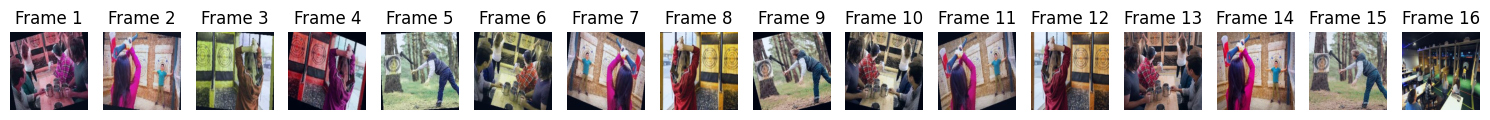

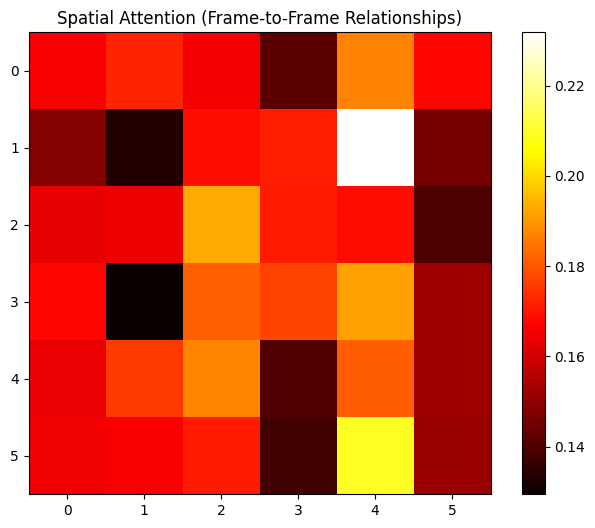

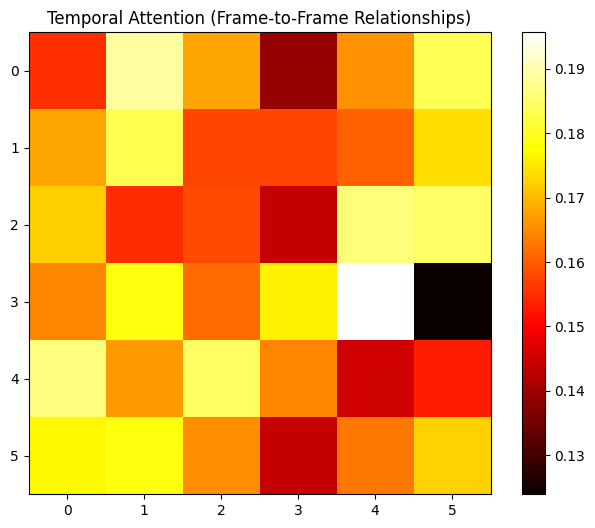

In [40]:
for inputs, labels in train_loader:
    inputs = inputs.to(device)

    # Forward pass through the model
    outputs, spatial_weights, temporal_weights = model(inputs)
    print(f"Shape of spatial weights: {spatial_weights.shape}")

    # Visualize attention for the first batch
    visualize_attention(inputs, spatial_weights, temporal_weights)
    break


Shape of spatial weights: torch.Size([8, 6, 6])


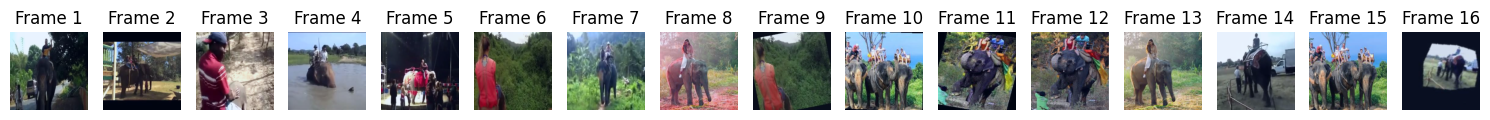

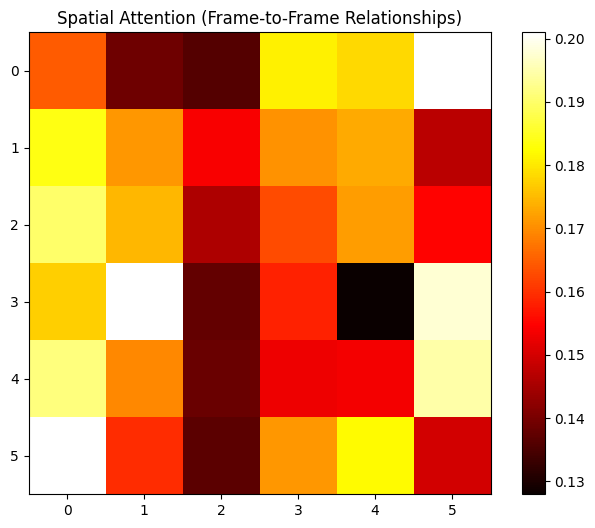

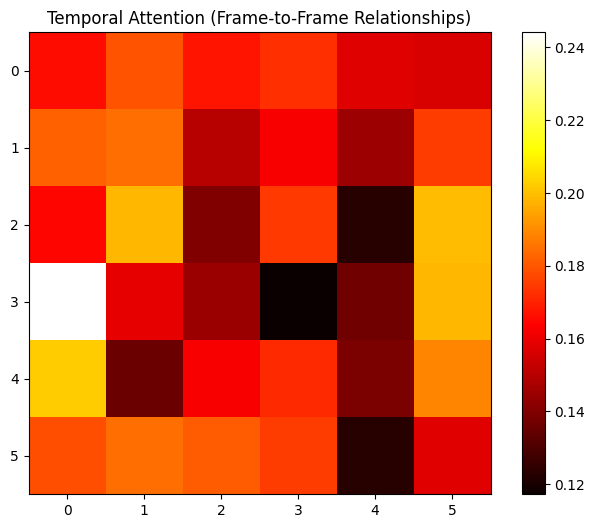

In [37]:
for inputs, labels in train_loader:
    inputs = inputs.to(device)

    # Forward pass through the model
    outputs, spatial_weights, temporal_weights = model(inputs)
    print(f"Shape of spatial weights: {spatial_weights.shape}")

    # Visualize attention for the first batch
    visualize_attention(inputs, spatial_weights, temporal_weights)
    break


In [15]:
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, RandomRotation, ColorJitter, Resize, ToTensor, Normalize
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [16]:
class_names = sorted(os.listdir("action_sp"))  # Adjust this path if needed

In [17]:
def train_model(model, train_loader, optimizer, scheduler, criterion, auxiliary_loss, device, num_epochs=200):
    losses = []
    lrs = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs, spatial_weights, temporal_weights = model(inputs)
            main_loss = criterion(outputs, labels)

            # Add auxiliary loss
            aux_loss = 0
            if spatial_weights is not None and temporal_weights is not None:
                aux_loss += (1 - auxiliary_loss(spatial_weights, temporal_weights).mean())  # Encourage similarity

            loss = main_loss + 0.1 * aux_loss  # Combine main and auxiliary loss
            loss.backward()

            optimizer.step()
            total_loss += loss.item()

        # Adjust learning rate
        scheduler.step(epoch + len(train_loader))
        avg_loss = total_loss / len(train_loader)

        # Record training loss and learning rate
        losses.append(avg_loss)
        lrs.append(scheduler.get_lr()[0])  # Get the current LR

        print(f"Epoch {epoch + 1}: Loss = {avg_loss:.6f}, LR = {scheduler.get_lr()[0]:.6e}")

    return losses, lrs


In [18]:
def evaluate_model(model, test_loader, device, class_names, top_k=3):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels, _ in test_loader:  # Video path not needed for accuracy
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Compute predictions
            logits = outputs[0]
            _, predicted = torch.max(logits, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Return accuracy
    accuracy = correct / total
    return accuracy


In [29]:
class RViT(nn.Module):
    def __init__(self, num_classes, hidden_dim, num_layers, frame_dim, dropout_rate=0.3):
        super().__init__()
        self.hidden_dim = hidden_dim

        # Patch embedding
        self.patch_embedding = nn.Conv3d(3, hidden_dim, kernel_size=(3, 8, 8), stride=(3, 4, 4), padding=(1, 2, 2))
        self.position_encoding = nn.Parameter(torch.randn(1, hidden_dim, 1, 56, 56), requires_grad=True)

        # Add relative positional embeddings for temporal modeling
        self.relative_positional_encoding = nn.Parameter(
            torch.randn(1, hidden_dim, 1, frame_dim[1], frame_dim[2]), requires_grad=True
        )

        # Spatiotemporal Transformer Units with the specified dropout rate
        self.rvit_units = nn.ModuleList(
            [RViTUnitWithTemporal(hidden_dim, dropout_rate=dropout_rate) for _ in range(num_layers)]
        )
        
        # Classifier
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Patch embedding
        patches = self.patch_embedding(x)

        # Add positional encoding
        _, _, depth, height, width = patches.shape
        pos_encoding = nn.functional.interpolate(
            self.position_encoding,
            size=(depth, height, width),
            mode='trilinear',
            align_corners=False
        )
        patches += pos_encoding

        # Resize relative positional encoding to match patch dimensions
        relative_pos_encoding = nn.functional.interpolate(
            self.relative_positional_encoding,
            size=(depth, height, width),
            mode='trilinear',
            align_corners=False
        )
        patches += relative_pos_encoding

        # Flatten spatial dimensions for temporal processing
        batch_size, hidden_dim, depth, height, width = patches.size()
        patches = patches.permute(0, 2, 1, 3, 4).reshape(batch_size, depth, hidden_dim, -1)
        patches = patches.mean(-1)  # Average pooling across spatial dimensions

        # Recurrent Spatiotemporal Processing
        spatial_weights, temporal_weights = None, None
        for unit in self.rvit_units:
            patches, spatial_weights, temporal_weights = unit(patches)

        # Classification
        h_last = patches.mean(dim=1)  # Global average pooling over the sequence length
        logits = self.classifier(h_last)

        return logits, spatial_weights, temporal_weights


class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.Wq = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wk = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wv = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.scale = hidden_dim ** -0.5

    def forward(self, x, h):
        # Compute queries, keys, and values
        q = self.Wq(x)
        k = self.Wk(h)
        v = self.Wv(h)
        
        # Compute scaled dot-product attention
        attn = torch.softmax((q * k).sum(dim=1, keepdim=True) * self.scale, dim=-1)
        output = attn * v  # Apply attention weights to values
        
        return output
        
class LinearAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.Wq = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wk = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wv = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wo = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)

    def forward(self, x, h):
        # Compute queries, keys, and values
        q = self.Wq(x)  # Shape: [batch_size, hidden_dim, depth, height, width]
        k = self.Wk(h)  # Shape: [batch_size, hidden_dim, depth, height, width]
        v = self.Wv(h)  # Shape: [batch_size, hidden_dim, depth, height, width]
        
        # Reshape q and k for attention computation
        q = q.flatten(start_dim=2)  # Shape: [batch_size, hidden_dim, depth*height*width]
        k = k.flatten(start_dim=2)  # Shape: [batch_size, hidden_dim, depth*height*width]
        v = v.flatten(start_dim=2)  # Shape: [batch_size, hidden_dim, depth*height*width]

        # Compute attention weights
        attn_weights = torch.bmm(q.transpose(1, 2), k)  # Shape: [batch_size, depth*height*width, depth*height*width]
        attn_weights = attn_weights / (k.size(1) ** 0.5)  # Scale by sqrt of hidden_dim
        attn_weights = torch.softmax(attn_weights, dim=-1)  # Apply softmax over last dimension

        # Apply attention weights to values
        attn_output = torch.bmm(v, attn_weights.transpose(1, 2))  # Shape: [batch_size, hidden_dim, depth*height*width]
        
        # Reshape back to 3D
        attn_output = attn_output.view_as(h)  # Shape: [batch_size, hidden_dim, depth, height, width]

        # Final projection to match the input shape
        output = self.Wo(attn_output)  # Shape: [batch_size, hidden_dim, depth, height, width]
        return output

class SpatiotemporalAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.spatial_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8, batch_first=True)
        self.temporal_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8, batch_first=True)
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        # x: [batch_size, sequence_length, hidden_dim]
        if x.ndim != 3:
            raise ValueError(f"Expected input shape [batch_size, sequence_length, hidden_dim], got {x.shape}")
        # print(f"Input shape to spatial attention: {x.shape}")

        # Spatial attention
        spatial_out, spatial_weights = self.spatial_attention(x, x, x)
        spatial_out = self.layer_norm1(x + spatial_out)   # Add & Norm

        # Temporal attention
        temporal_out, temporal_weights = self.temporal_attention(spatial_out, spatial_out, spatial_out)
        temporal_out = self.layer_norm2(spatial_out + temporal_out)  # Add & Norm

        return temporal_out, spatial_weights, temporal_weights


class RViTUnitWithTemporal(nn.Module):
    def __init__(self, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.spatial_temporal_block = SpatiotemporalAttention(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        # x: [batch_size, sequence_length, hidden_dim]
        if x.ndim != 3:
            raise ValueError(f"Expected input shape [batch_size, sequence_length, hidden_dim], got {x.shape}")

        # Spatiotemporal attention
        attention_out, spatial_weights, temporal_weights = self.spatial_temporal_block(x)
        attention_out = self.dropout(attention_out)

        # Feedforward network
        ffn_out = self.ffn(attention_out)
        output = self.layer_norm(attention_out + ffn_out)  # Add & Norm

        return output, spatial_weights, temporal_weights

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
model = RViT(
        num_classes=len(class_names),
        hidden_dim=256,         # Replace with your actual hidden_dim
        num_layers=6,           # Replace with your actual num_layers
        frame_dim=(16, 56, 56), # Replace with your actual frame dimensions
        dropout_rate= 0.2
    ).to(device)

In [20]:
import matplotlib.pyplot as plt

def objective(trial):
    # Suggest hyperparameters
    # lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)  # Learning rate range
    # weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)  # Weight decay range
    # T_0 = trial.suggest_int("T_0", 5, 100, step=5)  # T_0 in steps of 5
    # dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)  # Dropout rate range
    lr = trial.suggest_loguniform("lr", 2e-5, 2e-3)  # Learning rate range
    weight_decay = trial.suggest_loguniform("weight_decay", 2e-5, 2e-3)  # Weight decay range
    T_0 = trial.suggest_int("T_0", 5, 100, step=5)  # T_0 in steps of 5
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3)  # Dropout rate range
    
    # Initialize the model with the suggested dropout rate
    model = RViT(
        num_classes=len(class_names),
        hidden_dim=256,         # Replace with your actual hidden_dim
        num_layers=6,           # Replace with your actual num_layers
        frame_dim=(16, 56, 56), # Replace with your actual frame dimensions
        dropout_rate=dropout_rate
    ).to(device)

    # Optimizer, criterion, scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    auxiliary_loss = nn.CosineSimilarity(dim=1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=2)

    # Track losses and learning rates
    losses = []
    lrs = []

    # Training loop
    for epoch in range(50):  # Adjust number of epochs as needed
        model.train()
        total_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs, spatial_weights, temporal_weights = model(inputs)
            main_loss = criterion(outputs, labels)

            # Add auxiliary loss
            aux_loss = 0
            if spatial_weights is not None and temporal_weights is not None:
                aux_loss += (1 - auxiliary_loss(spatial_weights, temporal_weights).mean())

            loss = main_loss + 0.1 * aux_loss  # Combine main and auxiliary loss
            loss.backward()

            optimizer.step()
            total_loss += loss.item()

        # Adjust learning rate
        scheduler.step(epoch + len(train_loader))
        avg_loss = total_loss / len(train_loader)

        # Record training loss and learning rate
        losses.append(avg_loss)
        lrs.append(scheduler.get_lr()[0])

    # Evaluate the model
    accuracy = evaluate_model(model, test_loader, device, class_names)

    # Attach the training metrics for later plotting
    trial.set_user_attr("losses", losses)
    trial.set_user_attr("lrs", lrs)

    return accuracy  # Optuna will maximize this value


In [21]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)  # Adjust the number of trials

# Output the best parameters and accuracy
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2024-12-06 15:53:05,772] A new study created in memory with name: no-name-b14ea45f-8d03-4a8d-901a-dab57d606fde
/var/folders/7s/1w8zmpts3jzbt7l9vd8hc7rc0000gn/T/ipykernel_5880/1394298610.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 2e-5, 2e-3)  # Learning rate range
/var/folders/7s/1w8zmpts3jzbt7l9vd8hc7rc0000gn/T/ipykernel_5880/1394298610.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 2e-5, 2e-3)  # Weight decay range
[I 2024-12-06 15:53:55,532] Trial 0 finished with value: 0.047619047619047616 and parameters: {'lr': 0.0016032737235370466, 'weight_decay': 0.000137

Best parameters: {'lr': 0.00010398206059618094, 'weight_decay': 2.7714865340663196e-05, 'T_0': 5, 'dropout_rate': 0.17805325738263106}
Best accuracy: 0.19047619047619047


Best Parameters: {'lr': 0.00010398206059618094, 'weight_decay': 2.7714865340663196e-05, 'T_0': 5, 'dropout_rate': 0.17805325738263106}

In [ ]:
# Best parameters from Optuna
best_params = study.best_params
print("Best Parameters:", best_params)

# Initialize model with best dropout rate
model = RViT(
    num_classes=len(class_names),
    hidden_dim=256,  # Replace with your actual hidden_dim
    num_layers=6,    # Replace with your actual num_layers
    frame_dim=(16, 56, 56),
    dropout_rate=best_params['dropout_rate']
).to(device)

# Optimizer, criterion, and scheduler
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=best_params['lr'],
    weight_decay=best_params['weight_decay']
)
criterion = nn.CrossEntropyLoss()
auxiliary_loss = nn.CosineSimilarity(dim=1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=best_params['T_0'], T_mult=2
)

Best Parameters: {'lr': 0.00010398206059618094, 'weight_decay': 2.7714865340663196e-05, 'T_0': 5, 'dropout_rate': 0.17805325738263106}


In [25]:
# Initialize lists to store metrics
train_losses = []
learning_rates = []
val_accuracies = []

# Training loop
for epoch in range(200):  # Adjust as needed
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs, spatial_weights, temporal_weights = model(inputs)
        main_loss = criterion(outputs, labels)

        # Auxiliary loss
        aux_loss = 0
        if spatial_weights is not None and temporal_weights is not None:
            aux_loss += (1 - auxiliary_loss(spatial_weights, temporal_weights).mean())

        loss = main_loss + 0.1 * aux_loss
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    # Update scheduler
    scheduler.step(epoch + len(train_loader))
    avg_loss = total_loss / len(train_loader)

    # Validate model
    val_accuracy = evaluate_model(model, test_loader, device, class_names)

    # Store metrics
    train_losses.append(avg_loss)
    learning_rates.append(scheduler.get_lr()[0])
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}: Loss = {avg_loss:.6f}, LR = {scheduler.get_lr()[0]:.6e}, Val Acc = {val_accuracy:.4f}")


In [31]:
# Initialize lists to store metrics
train_losses = []
learning_rates = []
val_accuracies = []

# Training loop
for epoch in range(50):  # Adjust as needed
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs, spatial_weights, temporal_weights = model(inputs)
        main_loss = criterion(outputs, labels)

        # Auxiliary loss
        aux_loss = 0
        if spatial_weights is not None and temporal_weights is not None:
            aux_loss += (1 - auxiliary_loss(spatial_weights, temporal_weights).mean())

        loss = main_loss + 0.1 * aux_loss
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    # Update scheduler
    scheduler.step(epoch + len(train_loader))
    avg_loss = total_loss / len(train_loader)

    # Validate model
    val_accuracy = evaluate_model(model, test_loader, device, class_names)

    # Store metrics
    train_losses.append(avg_loss)
    learning_rates.append(scheduler.get_lr()[0])
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}: Loss = {avg_loss:.6f}, LR = {scheduler.get_lr()[0]:.6e}, Val Acc = {val_accuracy:.4f}")


Epoch 1: Loss = 3.370697, LR = 3.592492e-05, Val Acc = 0.1429
Epoch 2: Loss = 2.469060, LR = 9.929403e-06, Val Acc = 0.1905
Epoch 3: Loss = 2.366198, LR = 1.039821e-04, Val Acc = 0.1429
Epoch 4: Loss = 2.326950, LR = 1.014374e-04, Val Acc = 0.0952
Epoch 5: Loss = 1.971396, LR = 9.405266e-05, Val Acc = 0.0476
Epoch 6: Loss = 1.751815, LR = 8.255059e-05, Val Acc = 0.0476
Epoch 7: Loss = 1.589937, LR = 6.805714e-05, Val Acc = 0.0476
Epoch 8: Loss = 1.465257, LR = 5.199103e-05, Val Acc = 0.0476
Epoch 9: Loss = 1.361268, LR = 3.592492e-05, Val Acc = 0.0476
Epoch 10: Loss = 1.319123, LR = 2.143147e-05, Val Acc = 0.0952
Epoch 11: Loss = 1.305158, LR = 9.929403e-06, Val Acc = 0.0476
Epoch 12: Loss = 1.252362, LR = 2.544622e-06, Val Acc = 0.0476
Epoch 13: Loss = 1.176758, LR = 1.039821e-04, Val Acc = 0.0952
Epoch 14: Loss = 1.170869, LR = 1.033420e-04, Val Acc = 0.0952
Epoch 15: Loss = 1.061441, LR = 1.014374e-04, Val Acc = 0.0952
Epoch 16: Loss = 0.947770, LR = 9.831538e-05, Val Acc = 0.0952
E

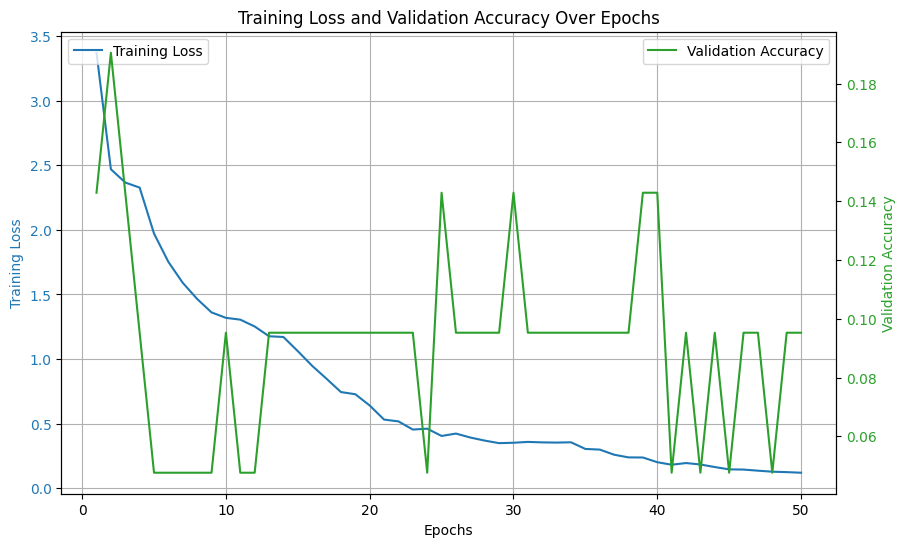

In [32]:
# Plot training loss and validation accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Training loss
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training Loss", color="tab:blue")
ax1.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.legend(loc="upper left")
ax1.grid()

# Validation accuracy on a secondary axis
ax2 = ax1.twinx()
ax2.set_ylabel("Validation Accuracy", color="tab:green")
ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")
ax2.legend(loc="upper right")

plt.title("Training Loss and Validation Accuracy Over Epochs")
plt.show()


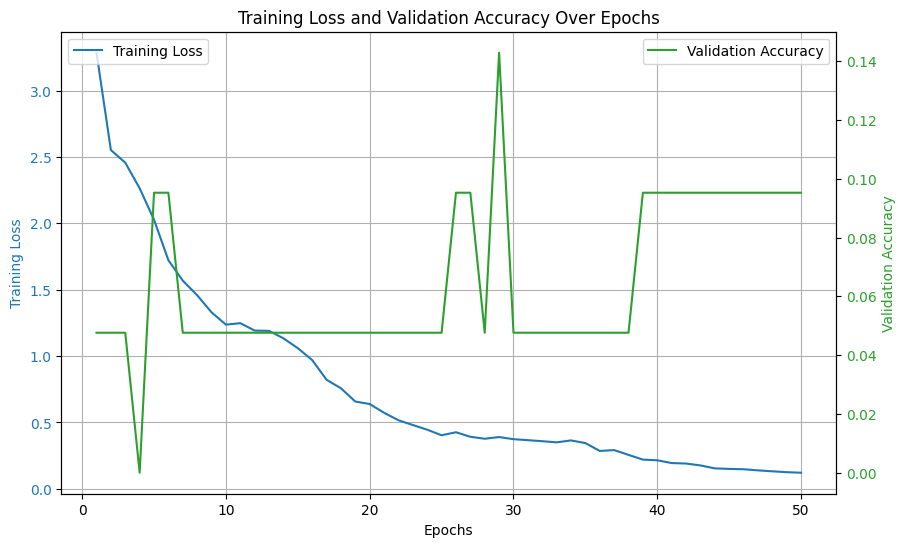

In [29]:
# Plot training loss and validation accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Training loss
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training Loss", color="tab:blue")
ax1.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.legend(loc="upper left")
ax1.grid()

# Validation accuracy on a secondary axis
ax2 = ax1.twinx()
ax2.set_ylabel("Validation Accuracy", color="tab:green")
ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")
ax2.legend(loc="upper right")

plt.title("Training Loss and Validation Accuracy Over Epochs")
plt.show()


In [23]:
import os

# Define class names dynamically based on the dataset
root_dir = "action_sp"  # Replace with the actual root directory
class_names = sorted(os.listdir(root_dir))  # Sorted to match class indices
print("Class Names:", class_names)

# Validation function
def validate_with_softmax(model, test_loader, device, class_names, top_k=3):
    model.eval()
    results = []
    output_file = "validation_results2.txt"  # Define the output file name

    with open(output_file, "w") as file:  # Open the file for writing
        with torch.no_grad():
            for inputs, labels, video_path in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                # Compute softmax probabilities
                logits = outputs[0]  # Extract the first element (logits) from the tuple
                probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities

                top_probs, top_classes = probs.topk(top_k, dim=1)  # Get top-k predictions
                
                # Collect results
                for i in range(len(video_path)):
                    video_name = video_path[i]
                    true_label = class_names[labels[i].item()]
                    predicted_probs = top_probs[i].cpu().numpy()
                    predicted_classes = [class_names[idx] for idx in top_classes[i].cpu().numpy()]
                    
                    result = {
                        "Video": video_name,
                        "True Label": true_label,
                        "Predicted Classes": predicted_classes,
                        "Probabilities": predicted_probs,
                    }
                    results.append(result)
                    
                    # Write to file
                    file.write(f"Video: {video_name}\n")
                    file.write(f"True Label: {true_label}\n")
                    file.write("Predicted Classes with Probabilities:\n")
                    for cls, prob in zip(predicted_classes, predicted_probs):
                        file.write(f"  {cls}: {prob:.4f}\n")
                    file.write("-" * 30 + "\n")
    
    return results

Class Names: ['abseiling', 'air drumming', 'answering questions', 'applauding', 'applying cream', 'archery', 'checking tires', 'doing aerobics', 'giving or receiving award', 'juggling soccer ball', 'milking cow', 'moving furniture', 'opening bottle', 'playing harp', 'playing trombone', 'pushing wheelchair', 'riding elephant', 'throwing axe', 'waxing chest', 'wrapping present', 'wrestling']


In [26]:
results = validate_with_softmax(model, test_loader, device, class_names, top_k=3)

# Display some validation results
for result in results[:5]:
    print(f"Video: {result['Video']}")
    print(f"True Label: {result['True Label']}")
    print("Predicted Classes with Probabilities:")
    for cls, prob in zip(result['Predicted Classes'], result['Probabilities']):
        print(f"  {cls}: {prob:.4f}")
    print("-" * 30)

print("Validation results saved to 'validation_results.txt'")